In [2]:
import pandas as pd 
import numpy as np
import cvxpy as cp
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [4]:
point_in_time_universe = pd.read_csv("/Users/donika/Downloads/all_data/point_in_time_universe.csv")
point_in_time_universe

,2015,2016,2017,2018,2019,2020,2021
0,OXY,OXY,OXY,VZ,OXY,AXP,AXP
1,AXP,AXP,AXP,HD,AXP,MDLZ,MDLZ
2,MDLZ,MDLZ,MDLZ,ACN,MDLZ,VZ,VZ
3,VZ,VZ,VZ,WMT,VZ,BA,BA
4,BA,BA,BA,ABT,BA,CAT,CAT
...,...,...,...,...,...,...,...
97,COF,LMT,COF,COF,ABBV,COF,COF
98,TFCFA,COF,TFCFA,TFCFA,DHR,NKE,NKE
99,NKE,TFCFA,NKE,NKE,AGN,DD,DD
100,NSC,NKE,DD,DD,MS,WFC,WFC


In [5]:
#I don't consider the quarterly S&P 100 (OEX) quarterly rebalancing due to lack of quarterly data.
point_in_time_monthly = point_in_time_universe[point_in_time_universe.columns.repeat(12)]
point_in_time_monthly.columns = [f'{a}-{b}' for a in point_in_time_universe for b in np.arange(1,13)]
point_in_time_monthly

,2015-1,2015-2,2015-3,2015-4,2015-5,2015-6,2015-7,2015-8,2015-9,2015-10,...,2021-3,2021-4,2021-5,2021-6,2021-7,2021-8,2021-9,2021-10,2021-11,2021-12
0,OXY,OXY,OXY,OXY,OXY,OXY,OXY,OXY,OXY,OXY,...,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP
1,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP,...,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ
2,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,...,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ
3,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ,...,BA,BA,BA,BA,BA,BA,BA,BA,BA,BA
4,BA,BA,BA,BA,BA,BA,BA,BA,BA,BA,...,CAT,CAT,CAT,CAT,CAT,CAT,CAT,CAT,CAT,CAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,COF,COF,COF,COF,COF,COF,COF,COF,COF,COF,...,COF,COF,COF,COF,COF,COF,COF,COF,COF,COF
98,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,...,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE
99,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE,...,DD,DD,DD,DD,DD,DD,DD,DD,DD,DD
100,NSC,NSC,NSC,NSC,NSC,NSC,NSC,NSC,NSC,NSC,...,WFC,WFC,WFC,WFC,WFC,WFC,WFC,WFC,WFC,WFC


In [6]:
universe = pd.read_csv("/Users/donika/Downloads/all_data/universe.csv")
universe

,Ticker,Name,Sector,RepRisk_ID
0,AAPL,Apple Inc,Technology,16
1,ABBV,AbbVie Inc,Health Care,104428
2,ABT,Abbott Laboratories,Health Care,280
3,ACN,Accenture,Technology,2972
4,ADBE,Adobe Systems Inc,Technology,6351
...,...,...,...,...
111,VZ,Verizon Communications,Telecommunications Services,2969
112,WBA,Walgreens Boots Alliance Inc,Consumer Staples,1548622
113,WFC,Wells Fargo,Financials,113
114,WMT,Walmart Stores,Consumer Staples,112


In [7]:
#ESG Data is Wharton Research Data Services. Data vendor - RepRisk
#ESG Risk core = Reputational risk exposure of a company related to ESG issues.
#ESG Trend score = Current ESG Risk Score - ESG Risk Score at T-30. 
esg_data = pd.read_csv("/Users/donika/Downloads/all_data/esg_history.csv")

#Join with Universe table on RepRisk_ID
esg_data = esg_data.merge(universe[["Ticker", "Sector", "RepRisk_ID"]], on = "RepRisk_ID", how = "left")
esg_data = esg_data[['RepRisk_ID', 'Ticker', 'name', 'date', 'current_RRI', 'RRI_trend', 
             'peak_RRI','peak_RRI_date', 'RepRisk_rating', 'country_sector_average',
             'environmental_percentage', 'social_percentage','governance_percentage', 'Sector']]
esg_data["date"] = pd.to_datetime(esg_data["date"], format="%Y%m%d")
esg_data["year"] = pd.DatetimeIndex(esg_data["date"]).year
esg_data["month"] = pd.DatetimeIndex(esg_data["date"]).month
esg_data = esg_data.sort_values(by=['date', 'Ticker'])

display(esg_data)

,RepRisk_ID,Ticker,name,date,current_RRI,RRI_trend,peak_RRI,peak_RRI_date,RepRisk_rating,country_sector_average,environmental_percentage,social_percentage,governance_percentage,Sector,year,month
2688,16,AAPL,Apple Inc (Apple),2007-01-31,42,3,60,20060926.0,CCC,38,70%,30%,0%,Technology,2007,1
168,104428,ABBV,AbbVie Inc,2007-01-31,0,0,0,NaN,AAA,19,0%,0%,0%,Health Care,2007,1
7056,280,ABT,Abbott Laboratories Inc (Abbott),2007-01-31,13,-1,20,20060814.0,AA,19,0%,0%,0%,Health Care,2007,1
8400,2972,ACN,Accenture PLC,2007-01-31,0,0,0,NaN,AAA,0,0%,0%,0%,Technology,2007,1
14280,6351,ADBE,Adobe Inc (formerly Adobe Systems Inc),2007-01-31,0,0,0,NaN,AA,24,0%,0%,0%,Technology,2007,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6047,2463,V,Visa Inc,2020-12-31,52,27,52,20201220.0,BB,26,0%,56%,44%,Technology,2020,12
8399,2969,VZ,Verizon Communications Inc (Verizon),2020-12-31,24,-1,59,20190101.0,CCC,32,4%,80%,16%,Telecommunications Services,2020,12
1175,113,WFC,Wells Fargo & Co,2020-12-31,54,-4,60,20190318.0,CCC,30,20%,32%,48%,Financials,2020,12
671,112,WMT,Walmart Inc (formerly Wal-Mart Stores Inc; Wal...,2020-12-31,61,1,62,20191025.0,CCC,35,13%,56%,31%,Consumer Staples,2020,12


In [8]:
#find the number of NaN in each column of ESG data
esg_data.isna().sum()

RepRisk_ID                     0
Ticker                         0
name                           0
date                           0
current_RRI                    0
RRI_trend                      0
peak_RRI                       0
peak_RRI_date               2056
RepRisk_rating                 0
country_sector_average         0
environmental_percentage       0
social_percentage              0
governance_percentage          0
Sector                         0
year                           0
month                          0
dtype: int64

In [9]:
#top 25 companies with the lowest ESG Risk score
esg_data[(esg_data["year"] == 2020) & (esg_data["month"] == 8)].sort_values(by="current_RRI").iloc[-25:]

,RepRisk_ID,Ticker,name,date,current_RRI,RRI_trend,peak_RRI,peak_RRI_date,RepRisk_rating,country_sector_average,environmental_percentage,social_percentage,governance_percentage,Sector,year,month
4531,20,BAC,Bank of America Corp (BOA),2020-08-31,45,-4,60,20190327.0,CCC,33,12%,33%,55%,Financials,2020,8
1171,113,WFC,Wells Fargo & Co,2020-08-31,46,0,60,20190318.0,B,29,16%,31%,53%,Financials,2020,8
15955,665,COST,Costco Wholesale Corp (Costco),2020-08-31,48,13,57,20191023.0,CCC,34,29%,46%,25%,Consumer Staples,2020,8
1507,1143,DUK,Duke Energy Corp (Duke),2020-08-31,49,12,50,20200813.0,BB,23,54%,41%,5%,Utilities,2020,8
13603,63,GE,General Electric Co (GE),2020-08-31,49,4,63,20180901.0,CC,39,17%,32%,51%,Industrials,2020,8
10915,3686,FDX,FedEx Corp,2020-08-31,51,-4,57,20200803.0,B,29,5%,68%,27%,Industrials,2020,8
11083,4204,BLK,BlackRock Inc,2020-08-31,51,0,58,20190923.0,CCC,34,39%,31%,30%,Financials,2020,8
18139,862,BA,Boeing Co; The,2020-08-31,51,1,69,20190517.0,C,41,10%,44%,46%,Industrials,2020,8
3854,178517,GOOG,Alphabet Inc,2020-08-31,51,-12,67,20200102.0,CCC,29,4%,49%,47%,Technology,2020,8
7723,286,JNJ,Johnson & Johnson (J&J),2020-08-31,51,0,68,20190531.0,CC,32,10%,23%,67%,Health Care,2020,8


In [10]:
tickers_found = np.unique(esg_data.Ticker)

#tickers not found is ESG Data
tickers_not_found = [ticker for ticker in universe.Ticker if ticker not in tickers_found]
tickers_not_found

['EMC', 'KMI', 'UNH', 'WBA']

In [11]:
#monthly price data 
price = pd.read_csv("/Users/donika/Downloads/all_data/price.csv")

#set date as row index
price = price.set_index("Date")

price = price[list(tickers_found)].dropna(axis = 0, how = 'all')
price = price.ffill()
price

,AAPL,ABBV,ABT,ACN,ADBE,AGN,AIG,ALL,AMGN,AMT,...,TWX,TXN,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
02-01-2015,27.333,65.89,44.90,88.84,72.340,259.13,56.11,70.12,159.89,99.67,...,84.93,53.480,118.61,110.38,44.83,66.2550,46.96,54.70,85.90,92.83
05-01-2015,26.563,64.65,44.91,87.34,71.980,256.69,55.00,68.73,157.99,98.23,...,83.24,52.645,114.60,108.17,43.75,64.7925,46.57,53.20,85.65,90.29
06-01-2015,26.565,64.33,44.40,86.71,70.530,255.17,54.22,68.68,152.90,97.97,...,82.30,51.780,112.23,107.46,43.17,64.3750,47.04,52.09,86.31,89.81
07-01-2015,26.938,66.93,44.76,88.53,71.110,265.23,54.48,69.81,158.24,99.00,...,83.17,52.710,112.85,108.46,43.55,65.2375,46.19,52.40,88.60,90.72
08-01-2015,27.973,67.63,45.68,89.88,72.915,268.96,54.24,71.15,157.67,99.92,...,85.49,53.570,117.08,110.41,43.87,66.1125,47.18,53.56,90.47,92.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
04-11-2022,138.380,145.28,98.07,261.16,285.750,193.02,57.92,129.12,269.04,203.92,...,98.77,162.650,196.70,165.69,42.83,196.9800,37.24,46.74,140.97,112.31
07-11-2022,138.920,148.10,99.50,269.07,299.540,193.02,59.17,128.82,277.02,202.02,...,98.77,165.690,196.30,169.13,43.53,200.1000,37.19,47.07,142.45,113.64
08-11-2022,139.500,148.53,99.64,269.03,302.170,193.02,59.13,130.26,292.39,203.02,...,98.77,168.110,204.01,168.79,44.17,201.7800,37.87,47.18,142.79,114.00


In [12]:
#Get price returns for all the tickers
price_returns = (price - price.shift(1)) / price.shift(1)
price_returns = price_returns.iloc[1:,:]
price_returns.index = pd.to_datetime(price_returns.index, format='%d-%m-%Y')
price_returns["year"] = price_returns.index.year
price_returns["month"] = price_returns.index.month
price_returns

,AAPL,ABBV,ABT,ACN,ADBE,AGN,AIG,ALL,AMGN,AMT,...,UNP,UPS,USB,V,VZ,WFC,WMT,XOM,year,month
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.028171,-0.018819,0.000223,-0.016884,-0.004976,-0.009416,-0.019783,-0.019823,-0.011883,-0.014448,...,-0.033808,-0.020022,-0.024091,-0.022074,-0.008305,-0.027422,-0.002910,-0.027362,2015,1
2015-01-06,0.000075,-0.004950,-0.011356,-0.007213,-0.020144,-0.005922,-0.014182,-0.000727,-0.032217,-0.002647,...,-0.020681,-0.006564,-0.013257,-0.006444,0.010092,-0.020865,0.007706,-0.005316,2015,1
2015-01-07,0.014041,0.040417,0.008108,0.020990,0.008223,0.039425,0.004795,0.016453,0.034925,0.010513,...,0.005524,0.009306,0.008802,0.013398,-0.018070,0.005951,0.026532,0.010133,2015,1
2015-01-08,0.038422,0.010459,0.020554,0.015249,0.025383,0.014063,-0.004405,0.019195,-0.003602,0.009293,...,0.037483,0.017979,0.007348,0.013413,0.021433,0.022137,0.021106,0.016645,2015,1
2015-01-09,0.001072,-0.027355,-0.010508,-0.001113,-0.014743,-0.001041,-0.016962,-0.010260,-0.012304,-0.005104,...,-0.017936,-0.007336,-0.020743,-0.014823,-0.008902,-0.016430,-0.012380,-0.001410,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,-0.003600,0.005955,0.016796,0.016661,-0.000630,0.000000,0.005381,0.041626,0.011885,0.012864,...,0.018169,0.010243,0.032048,0.011451,0.002423,0.026350,0.001777,0.010891,2022,11
2022-11-07,0.003902,0.019411,0.014581,0.030288,0.048259,0.000000,0.021581,-0.002323,0.029661,-0.009317,...,-0.002034,0.020762,0.016344,0.015839,-0.001343,0.007060,0.010499,0.011842,2022,11
2022-11-08,0.004175,0.002903,0.001407,-0.000149,0.008780,0.000000,-0.000676,0.011178,0.055483,0.004950,...,0.039277,-0.002010,0.014703,0.008396,0.018284,0.002337,0.002387,0.003168,2022,11


In [13]:
#Get the S&P 100 returns.
oex = yf.download('^OEX', start='2015-01-01', end='2021-01-01')['Adj Close']

oex_returns = (oex-oex.shift(1)) / oex.shift(1)
oex_returns = oex_returns.iloc[1:]
oex_returns = pd.DataFrame(oex_returns)
oex_returns["year"] = oex_returns.index.year
oex_returns["month"] = oex_returns.index.month
oex_returns


[*********************100%%**********************]  1 of 1 completed


,Adj Close,year,month
Date,,,
2015-01-05,-0.018138,2015,1
2015-01-06,-0.007946,2015,1
2015-01-07,0.010905,2015,1
2015-01-08,0.018207,2015,1
2015-01-09,-0.008507,2015,1
...,...,...,...
2020-12-24,0.003262,2020,12
2020-12-28,0.012037,2020,12
2020-12-29,-0.001160,2020,12


# Utility Functions

In [14]:
def markowitz(mu, Sigma, gamma_range=[-1, 4], SAMPLES = 100):
  n = len(mu)
  w = cp.Variable(n)
  
  #risk aversion coeefincient
  gamma = cp.Parameter(nonneg=True)
  
  #expected return
  ret = w @ mu 

  #define risk using the quadratic form
  risk = cp.quad_form(w, Sigma)

  #formulate the problem. Objective is to maximize risk adjusted return. Constraints :- weights sum to 1 and are non-negative.
  #gamma is the risk aversion parameter
  prob = cp.Problem(cp.Maximize(ret - gamma * risk), [cp.sum(w) == 1, w >= 0])

  risk_data = np.zeros(SAMPLES)
  ret_data = np.zeros(SAMPLES)
  w_data = []
  gamma_vals = np.logspace(gamma_range[0], gamma_range[1], num=SAMPLES)
  for i in range(SAMPLES):
      gamma.value = gamma_vals[i]
      prob.solve()
      risk_data[i] = cp.sqrt(risk).value
      ret_data[i] = ret.value
      w_data.append(w.value)
  return ret_data, risk_data, w_data

def markowitz_beta(mu, Sigma, betas, target_beta=1):
    n = len(mu)
    w = cp.Variable(n)
    ret = w @ mu
    risk = cp.quad_form(w, Sigma)
    beta = w @ betas

    #formulate the problem. Objective is to minimize risk. Constraints :- weights sum to 1, are non-negative and maintain market neutrality
    prob = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1,  w >= 0, beta<=target_beta+0.05, beta>=target_beta-0.05])
    prob.solve()
    risk_data = cp.sqrt(risk).value
    ret_data = ret.value
    w_data = w.value

    return ret_data, risk_data, w_data

In [15]:
def markowitz_esg_objective(mu, Sigma, esg_scores, target_ret, target_std):
  n = len(mu)
  w = cp.Variable(n)
  gamma = cp.Parameter(nonneg=True)
  ret = w @ mu
  esg = w @ esg_scores
  risk = cp.quad_form(w, Sigma)

  #formulate the problem. Objective is to minimize ESG risk. Constraints :- weights sum to 1, are non-negative and risk, return are bounded by targets
  prob = cp.Problem(cp.Minimize(esg), [cp.sum(w) == 1,  w >= 0, risk<=target_std**2, ret>=target_ret])
  prob.solve()
  risk_data = cp.sqrt(risk).value
  ret_data = ret.value
  w_data = w.value
  return ret_data, risk_data, w_data

def markowitz_beta_esg_objective(mu, Sigma, betas, esg_scores, target_beta=1):
    n = len(mu)
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = w @ mu
    esg = w @ esg_scores
    risk = cp.quad_form(w, Sigma)
    beta = w @ betas

    #formulate the problem. Objective is to minimize ESG risk. Constraints :- weights sum to 1, are non-negative, maintain market neutrality
    prob = cp.Problem(cp.Minimize(esg), [cp.sum(w) == 1,  w >= 0, beta<=target_beta+0.05, beta>=target_beta-0.05])
    prob.solve()
    risk_data = cp.sqrt(risk).value
    ret_data = ret.value
    w_data = w.value

    return ret_data, risk_data, w_data

In [16]:
def markowitz_esg_constraint(mu, Sigma, esg_scores, target_esg_score, gamma_range=[-1, 4], SAMPLES = 100):
  n = len(mu)
  w = cp.Variable(n)
  gamma = cp.Parameter(nonneg=True)
  ret = w @ mu
  esg = w @ esg_scores
  risk = cp.quad_form(w, Sigma)
  
  #formulate the problem. Objective is to maximize risk adjusted return. Constraints :- weights sum to 1, are non-negative and ESG risk is bounded by target
  prob = cp.Problem(cp.Maximize(ret - gamma * risk), [cp.sum(w) == 1, w >= 0, esg<= target_esg_score])
  risk_data = np.zeros(SAMPLES)
  ret_data = np.zeros(SAMPLES)
  w_data = []
  gamma_vals = np.logspace(gamma_range[0], gamma_range[1], num=SAMPLES)
  for i in range(SAMPLES):
      gamma.value = gamma_vals[i]
      prob.solve()
      risk_data[i] = cp.sqrt(risk).value
      ret_data[i] = ret.value
      w_data.append(w.value)
  return ret_data, risk_data, w_data

def markowitz_beta_esg_constraint(mu, Sigma, betas, esg_scores, target_esg_score, target_beta=1):
    n = len(mu)
    w = cp.Variable(n)
    ret = w @ mu
    esg = w @ esg_scores
    risk = cp.quad_form(w, Sigma)
    beta = w @ betas

    #formulate the problem. Objective is to minimize risk. Constraints :- weights sum to 1, are non-negative, ESG risk is bounded by target & maintain market neutrality  
    prob = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1,  w >= 0, esg<= target_esg_score, beta<=target_beta+0.05, beta>=target_beta-0.05])
    prob.solve()
    risk_data = cp.sqrt(risk).value
    ret_data = ret.value
    w_data = w.value

    return ret_data, risk_data, w_data

In [17]:
def markowitz_esg(mu, Sigma, type, esg_scores, esg_mom, target_ret=0, target_std=0, target_esg=0):
  
  if(type == 'obj'):
    ret_data, risk_data, w_data = markowitz_esg_objective(mu, Sigma, esg_scores, target_ret, target_std)
    return ret_data, risk_data, w_data

  if(type == 'con'):
    ret_data_, risk_data_, w_data_ = markowitz_esg_constraint(mu, Sigma, esg_scores, target_esg)
    sharpe_data_ = ret_data_ / risk_data_
    ret_data = ret_data_[np.argmax(sharpe_data_)]
    risk_data = risk_data_[np.argmax(sharpe_data_)]
    w_data = w_data_[np.argmax(sharpe_data_)]
    return ret_data, risk_data, w_data
    
  if(type == 'adj_tilt'):
    ret_data_, risk_data_, w_data_ = markowitz(mu, Sigma)
    sharpe_data_ = ret_data_ / risk_data_
    ret_data = ret_data_[np.argmax(sharpe_data_)]
    risk_data = risk_data_[np.argmax(sharpe_data_)]
    w_data = w_data_[np.argmax(sharpe_data_)]
    w_data = [w_data[i] * (100-esg_scores[i]) for i in range(len(esg_scores))]
    w_data = [i / np.sum(w_data) for i in w_data]
    return None, None, w_data
  
  if(type == 'adj_mom'):
    ret_data_, risk_data_, w_data_ = markowitz(mu, Sigma)
    sharpe_data_ = ret_data_ / risk_data_
    ret_data = ret_data_[np.argmax(sharpe_data_)]
    risk_data = risk_data_[np.argmax(sharpe_data_)]
    w_data = w_data_[np.argmax(sharpe_data_)]
    w_data = [w_data[i] * (100-esg_mom[i]) for i in range(len(esg_mom))]
    w_data = [i / np.sum(w_data) for i in w_data]
    return None, None, w_data
  
def markowitz_beta_esg(mu, Sigma, type, betas, esg_scores, esg_mom, target_ret=0, target_std=0, target_esg=0, target_beta=1):
  
  if(type == 'obj'):
    ret_data, risk_data, w_data = markowitz_beta_esg_objective(mu, Sigma, betas, esg_scores)
    return ret_data, risk_data, w_data

  if(type == 'con'):
    ret_data, risk_data, w_data = markowitz_beta_esg_constraint(mu, Sigma, betas, esg_scores, target_esg)
    return ret_data, risk_data, w_data
    
  if(type == 'adj_tilt'):
    ret_data, risk_data, w_data = markowitz_beta(mu, Sigma, betas)
    w_data = [w_data[i] * (100-esg_scores[i]) for i in range(len(esg_scores))]
    w_data = [i / np.sum(w_data) for i in w_data]
    return None, None, w_data
  
  if(type == 'adj_mom'):
    ret_data, risk_data, w_data = markowitz_beta(mu, Sigma, betas)
    w_data = [w_data[i] * (100-esg_mom[i]) for i in range(len(esg_mom))]
    w_data = [i / np.sum(w_data) for i in w_data]
    return None, None, w_data

# Strategies

## Classical Markotwitz

In [18]:
timeframes = list(point_in_time_monthly.columns)
PnL_df = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
ESG_df = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
main_list = []

for year in range (2015, 2021):
  for month in range(1, 13):

    if(month == 1): print(year)
    if year == 2015 and month != 12: continue
    if year == 2020 and month == 12: break

    sector_list = []

    # filter data for universe in current time frame
    sliced_data_returns = price_returns[(price_returns["year"] >= year-1)  & (price_returns["year"] <= year)]
    sliced_data_returns1 = sliced_data_returns[(price_returns["year"] == year-1) & (price_returns["month"] > month)]
    sliced_data_returns2 = sliced_data_returns[(price_returns["year"] == year) & (price_returns["month"] <= month)]
    sliced_data_returns = pd.concat([sliced_data_returns1, sliced_data_returns2], axis = 0)

    sliced_data_esg = esg_data[(esg_data["year"] == year) & (esg_data["month"] == month)]
    uni_index = timeframes.index(str(year)+'-'+str(month))+1
    univ = list(point_in_time_monthly.iloc[:,uni_index])
    univ_found = [i for i in univ if i in tickers_found]
    sliced_data_returns = sliced_data_returns[univ_found].dropna(axis = 1, how = 'any')
    univ_found = list(sliced_data_returns.columns)
    sliced_data_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
    holding_returns = price_returns[(price_returns["year"] == int(timeframes[uni_index][:4])) & 
                                    (price_returns["month"] == int(timeframes[uni_index][5:]))][univ_found]
    holding_esg = esg_data[(esg_data["year"] == int(timeframes[uni_index][:4])) & 
                                    (esg_data["month"] == int(timeframes[uni_index][5:]))]
    holding_esg = holding_esg[holding_esg.Ticker.isin(univ_found)]
    sector_df = holding_esg[["Ticker", "Sector"]]
    mu = sliced_data_returns.mean()
    Sigma = sliced_data_returns.cov()
    
    # strategy 1
    
    no_esg_ret_data, no_esg_risk_data, no_esg_w_data = markowitz(mu, Sigma)
    no_esg_sharpe_data = no_esg_ret_data / no_esg_risk_data
    no_esg_ret = no_esg_ret_data[np.argmax(no_esg_sharpe_data)]
    no_esg_risk = no_esg_risk_data[np.argmax(no_esg_sharpe_data)]
    no_esg_weights = no_esg_w_data[np.argmax(no_esg_sharpe_data)]
    no_esg_score = no_esg_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'No_ESG'] = (holding_returns * no_esg_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'No_ESG'] = no_esg_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = no_esg_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 2
    
    semi_esg_top_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[:25].Ticker.values)
    semi_esg_top_sliced_data_returns = sliced_data_returns[semi_esg_top_companies]
    semi_esg_top_holding_returns = holding_returns[semi_esg_top_companies]
    semi_esg_top_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_top_companies)]
    semi_esg_top_mu = semi_esg_top_sliced_data_returns.mean()
    semi_esg_top_Sigma = semi_esg_top_sliced_data_returns.cov()
    semi_esg_top_ret_data, semi_esg_top_risk_data, semi_esg_top_w_data = markowitz(semi_esg_top_mu, semi_esg_top_Sigma)
    semi_esg_top_sharpe_data = semi_esg_top_ret_data / semi_esg_top_risk_data
    semi_esg_top_ret = semi_esg_top_ret_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_risk = semi_esg_top_risk_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_weights = semi_esg_top_w_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_score = semi_esg_top_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_top_companies)].current_RRI.values
    PnL_df.loc[holding_returns.index, 'Semi_ESG_Top'] = (semi_esg_top_holding_returns * semi_esg_top_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Semi_ESG_Top'] = semi_esg_top_weights @ semi_esg_top_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_top_companies), "weights"] = semi_esg_top_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    semi_esg_bottom_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[-25:].Ticker.values)
    semi_esg_bottom_sliced_data_returns = sliced_data_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_returns = holding_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_bottom_companies)]
    semi_esg_bottom_mu = semi_esg_bottom_sliced_data_returns.mean()
    semi_esg_bottom_Sigma = semi_esg_bottom_sliced_data_returns.cov()
    semi_esg_bottom_ret_data, semi_esg_bottom_risk_data, semi_esg_bottom_w_data = markowitz(semi_esg_bottom_mu, semi_esg_bottom_Sigma)
    semi_esg_bottom_sharpe_data = semi_esg_bottom_ret_data / semi_esg_bottom_risk_data
    semi_esg_bottom_ret = semi_esg_bottom_ret_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_bottom_risk = semi_esg_bottom_risk_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_bottom_weights = semi_esg_bottom_w_data[np.argmax(semi_esg_bottom_sharpe_data)]
    semi_esg_bottom_score = semi_esg_bottom_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_bottom_companies)].current_RRI.values
    PnL_df.loc[holding_returns.index, 'Semi_ESG_Bottom'] = (semi_esg_bottom_holding_returns * semi_esg_bottom_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Semi_ESG_Bottom'] = semi_esg_bottom_weights @ semi_esg_bottom_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_bottom_companies), "weights"] = semi_esg_bottom_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 3
    # esg in objective (1 - vary min returns needed, 2 - vary max risk allowed)
    full_esg_obj1_ret, full_esg_obj1_risk, full_esg_obj1_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret-abs(no_esg_ret)*0.05, no_esg_risk)
    full_esg_obj1_score = full_esg_obj1_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'Full_ESG_Obj1'] = (holding_returns * full_esg_obj1_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Full_ESG_Obj1'] = full_esg_obj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())
    
    full_esg_obj2_ret, full_esg_obj2_risk, full_esg_obj2_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret, no_esg_risk*1.05)
    full_esg_obj2_score = full_esg_obj2_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'Full_ESG_Obj2'] = (holding_returns * full_esg_obj2_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Full_ESG_Obj2'] = full_esg_obj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())  

    # esg in constraint
    full_esg_con_ret, full_esg_con_risk, full_esg_con_weights = markowitz_esg(mu, Sigma, 'con', sliced_data_esg.current_RRI.values, 
                                                                              None, None, None, no_esg_score*0.95)
    full_esg_con_score = full_esg_con_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'Full_ESG_Con'] = (holding_returns * full_esg_con_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Full_ESG_Con'] = full_esg_con_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_con_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg to readjust (1 - tilt, 2 - momentum)
    full_esg_adj1_ret, full_esg_adj1_risk, full_esg_adj1_weights = markowitz_esg(mu, Sigma, 'adj_tilt', sliced_data_esg.current_RRI.values, 
                                                                                 None, None, None, None)
    full_esg_adj1_score = full_esg_adj1_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'Full_ESG_Tilt'] = (holding_returns * full_esg_adj1_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Full_ESG_Tilt'] = full_esg_adj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    full_esg_adj2_ret, full_esg_adj2_risk, full_esg_adj2_weights = markowitz_esg(mu, Sigma, 'adj_mom', sliced_data_esg.current_RRI.values, 
                                                                                 sliced_data_esg.RRI_trend.values, None, None, None)
    full_esg_adj2_score = full_esg_adj2_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'Full_ESG_Mom'] = (holding_returns * full_esg_adj2_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Full_ESG_Mom'] = full_esg_adj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    main_list.append(sector_list)


2015
2016
2017
2018
2019
2020


In [19]:
PnL_df_final = PnL_df.dropna()
PnL_df_final["OEX"] = oex_returns.loc[PnL_df_final.index,'Adj Close']
PnL_cumulative = (1 + PnL_df_final).cumprod()
PnL_cumulative

,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Date,,,,,,,,,
2016-01-04,0.957106,0.975593,0.953198,0.958196,0.95613,0.957306,0.958763,0.958477,0.983663
2016-01-05,0.958224,0.972557,0.951848,0.958313,0.955266,0.957948,0.960127,0.960174,0.984892
2016-01-06,0.953968,0.968021,0.947671,0.951975,0.949352,0.953009,0.955168,0.95571,0.972955
2016-01-07,0.921367,0.944107,0.91394,0.925236,0.92201,0.920124,0.922906,0.923513,0.948488
2016-01-08,0.917572,0.933638,0.911749,0.922274,0.918823,0.916305,0.919041,0.919502,0.938723
...,...,...,...,...,...,...,...,...,...
2020-12-24,2.903513,2.122541,4.272711,2.540722,2.650427,2.856459,2.337586,2.893707,1.859507
2020-12-28,2.912305,2.112913,4.306885,2.533284,2.638276,2.865909,2.343842,2.902423,1.881889
2020-12-29,2.913525,2.118742,4.310813,2.539812,2.644472,2.866171,2.341074,2.903484,1.879706


In [20]:
stats_df = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_df_final.columns)
stats_df.loc["Ann_Returns_comp", :] = PnL_cumulative.iloc[-1,:] ** (1/5) - 1
ann_return = PnL_df_final.mean(axis=0) * 252
ann_vol = PnL_df_final.std(axis=0) * (252)**(0.5)
stats_df.loc["Ann_Vol", :] = ann_vol
stats_df.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_df_final.sub(PnL_df_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_df.loc["Tracking_error", :] = tracking_error
stats_df.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_cumulative - PnL_cumulative.cummax())/ PnL_cumulative.cummax()).min(axis=0)
stats_df.loc["Max_drawdown", :] = mdd
stats_df.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_df_final[PnL_df_final<0].std(axis=0) * (252)**(0.5)
stats_df.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_df.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_df.loc["Avg_ESG", :] = ESG_df.mean(axis=0)
stats_df.loc["Sharpe/ESG", :] = stats_df.loc["Ann_Sharpe", :] / ESG_df.mean(axis=0)
stats_df.apply(lambda x: round(x.astype(float), 3))

,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Ann_Returns_comp,0.247,0.163,0.348,0.211,0.222,0.243,0.191,0.246,0.135
Ann_Vol,0.257,0.232,0.275,0.250,0.259,0.256,0.239,0.258,0.192
Ann_Sharpe,0.988,0.771,1.227,0.893,0.903,0.979,0.855,0.983,0.759
Tracking_error,0.180,0.143,0.190,0.162,0.171,0.176,0.156,0.180,NaN
Information_ratio,0.604,0.229,1.008,0.475,0.515,0.594,0.374,0.598,NaN
Max_drawdown,-0.324,-0.329,-0.254,-0.330,-0.330,-0.326,-0.324,-0.325,-0.315
Calmar_Ratio,0.785,0.542,1.329,0.675,0.710,0.768,0.629,0.781,0.462
Sortino_ratio,1.162,0.899,1.521,1.047,1.071,1.147,0.991,1.155,0.845
95var,-0.171,-0.204,-0.116,-0.189,-0.193,-0.171,-0.190,-0.172,-0.171
Avg_ESG,35.980,18.256,54.682,26.997,27.314,34.258,33.250,35.908,NaN


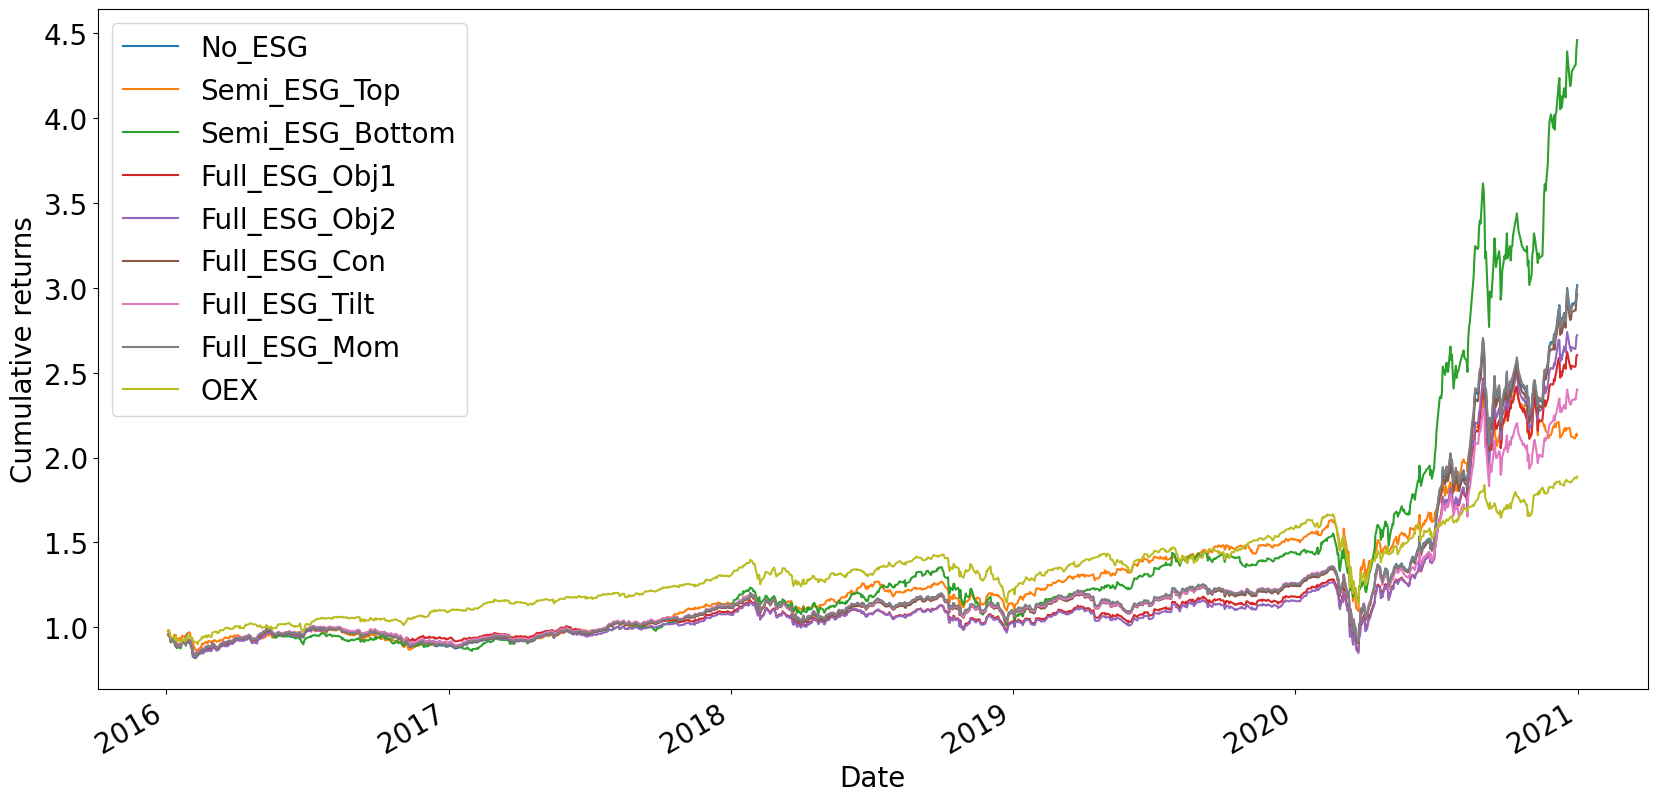

In [21]:
PnL_cumulative.plot(figsize=(20,10))
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Cumulative returns", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

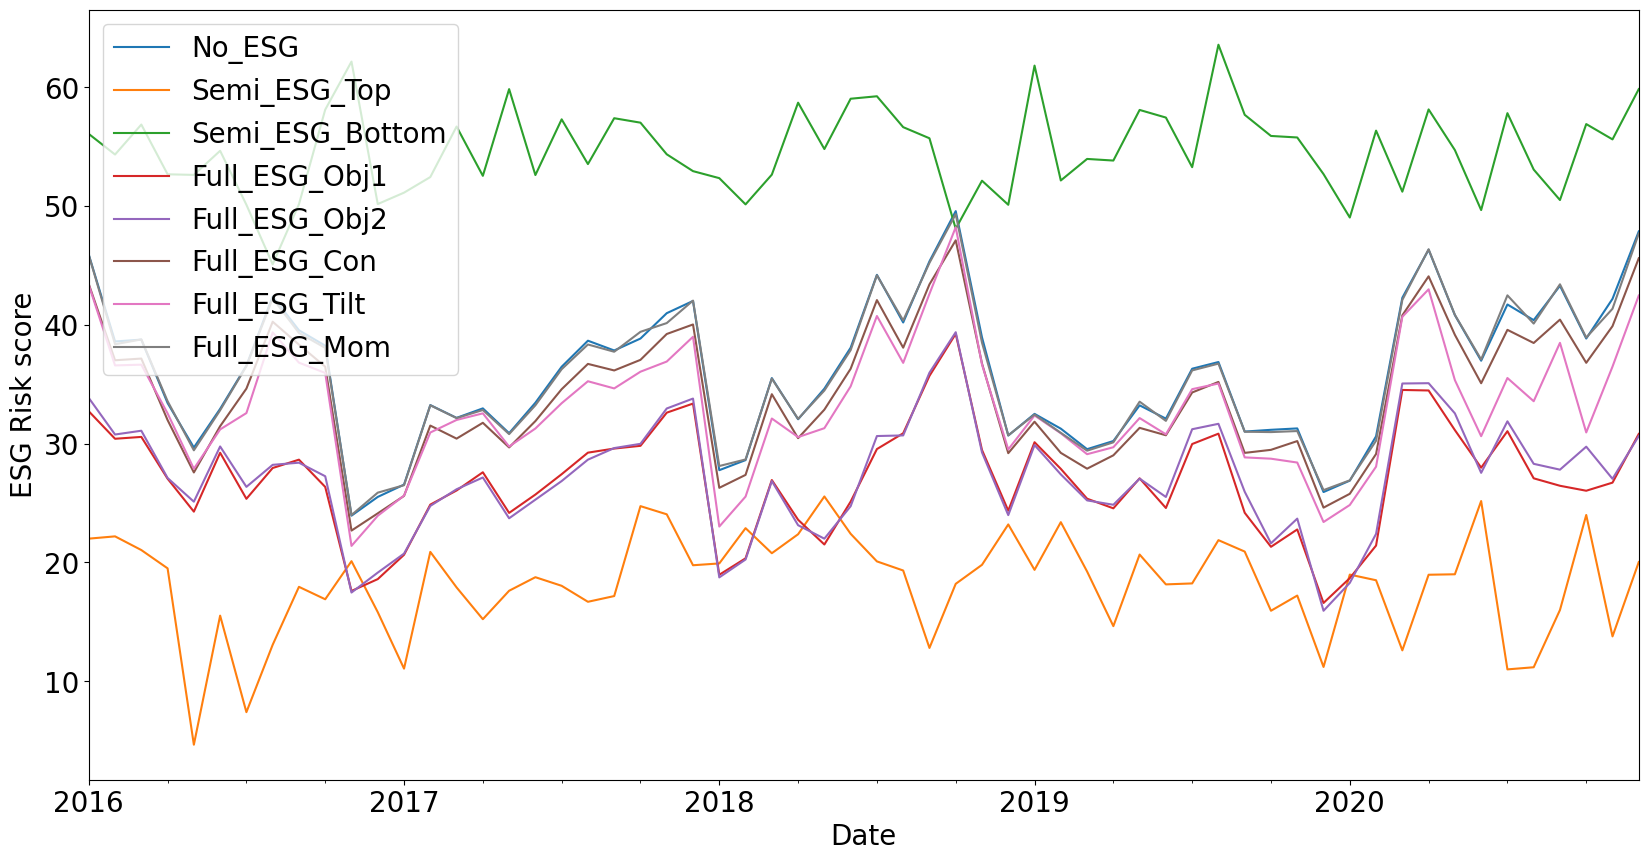

In [22]:
ESG_df.resample('M').mean().dropna().plot(figsize=(20,10))
plt.xlabel("Date", fontsize = 20)
plt.ylabel("ESG Risk score", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

## Index Tracking Markowitz

In [23]:
timeframes = list(point_in_time_monthly.columns)
PnL_df_betas = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
ESG_df_betas = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
main_list_betas = []

for year in range (2015, 2021):
  for month in range(1, 13):

    if(month == 1): print(year)
    if year == 2015 and month != 12: continue
    if year == 2020 and month == 12: break

    sector_list = []
    
    # filter data for universe in current time frame
    sliced_data_returns = price_returns[(price_returns["year"] >= year-1)  & (price_returns["year"] <= year)]
    sliced_data_returns1 = sliced_data_returns[(price_returns["year"] == year-1) & (price_returns["month"] > month)]
    sliced_data_returns2 = sliced_data_returns[(price_returns["year"] == year) & (price_returns["month"] <= month)]
    sliced_data_returns = pd.concat([sliced_data_returns1, sliced_data_returns2], axis = 0)

    sliced_oex_returns = oex_returns[(oex_returns["year"] >= year-1)  & (oex_returns["year"] <= year)]
    sliced_oex_returns1 = sliced_oex_returns[(sliced_oex_returns["year"] == year-1) & (sliced_oex_returns["month"] > month)]
    sliced_oex_returns2 = sliced_oex_returns[(sliced_oex_returns["year"] == year) & (sliced_oex_returns["month"] <= month)]
    sliced_oex_returns = pd.concat([sliced_oex_returns1, sliced_oex_returns2], axis = 0)

    sliced_data_esg = esg_data[(esg_data["year"] == year) & (esg_data["month"] == month)]
    uni_index = timeframes.index(str(year)+'-'+str(month))+1
    univ = list(point_in_time_monthly.iloc[:,uni_index])
    univ_found = [i for i in univ if i in tickers_found]
    sliced_data_returns = sliced_data_returns[univ_found].dropna(axis = 1, how = 'any')
    univ_found = list(sliced_data_returns.columns)
    sliced_data_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
    holding_returns = price_returns[(price_returns["year"] == int(timeframes[uni_index][:4])) & 
                                    (price_returns["month"] == int(timeframes[uni_index][5:]))][univ_found]
    holding_esg = esg_data[(esg_data["year"] == int(timeframes[uni_index][:4])) & 
                                (esg_data["month"] == int(timeframes[uni_index][5:]))]
    holding_esg = holding_esg[holding_esg.Ticker.isin(univ_found)]
    sector_df = holding_esg[["Ticker", "Sector"]]
    mu = sliced_data_returns.mean()
    Sigma = sliced_data_returns.cov()
    
    # Calculate betas
    betas = []
    for i in sliced_data_returns.columns:
      cov = np.cov(sliced_data_returns[i], sliced_oex_returns['Adj Close'])
      beta = cov[0,1]/cov[1,1]
      betas.append(beta)
    betas = pd.Series(betas, index=sliced_data_returns.columns)
    
    # strategy 1
    
    no_esg_ret, no_esg_risk, no_esg_weights = markowitz_beta(mu, Sigma, betas)
    no_esg_score = no_esg_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'No_ESG'] = (holding_returns * no_esg_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'No_ESG'] = no_esg_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = no_esg_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 2
    
    semi_esg_top_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[:25].Ticker.values)
    semi_esg_top_sliced_data_returns = sliced_data_returns[semi_esg_top_companies]
    semi_esg_top_holding_returns = holding_returns[semi_esg_top_companies]
    semi_esg_top_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_top_companies)]
    semi_esg_top_mu = semi_esg_top_sliced_data_returns.mean()
    semi_esg_top_Sigma = semi_esg_top_sliced_data_returns.cov()
    semi_esg_top_ret, semi_esg_top_risk, semi_esg_top_weights = markowitz_beta(semi_esg_top_mu, semi_esg_top_Sigma, betas[semi_esg_top_companies])
    semi_esg_top_score = semi_esg_top_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_top_companies)].current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Semi_ESG_Top'] = (semi_esg_top_holding_returns * semi_esg_top_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Semi_ESG_Top'] = semi_esg_top_weights @ semi_esg_top_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_top_companies), "weights"] = semi_esg_top_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    semi_esg_bottom_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[-25:].Ticker.values)
    semi_esg_bottom_sliced_data_returns = sliced_data_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_returns = holding_returns[semi_esg_bottom_companies]
    semi_esg_botom_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_bottom_companies)]
    semi_esg_bottom_mu = semi_esg_bottom_sliced_data_returns.mean()
    semi_esg_bottom_Sigma = semi_esg_bottom_sliced_data_returns.cov()
    semi_esg_bottom_ret, semi_esg_bottom_risk, semi_esg_bottom_weights = markowitz_beta(semi_esg_bottom_mu, semi_esg_bottom_Sigma, betas[semi_esg_bottom_companies])
    semi_esg_bottom_score = semi_esg_bottom_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_bottom_companies)].current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Semi_ESG_Bottom'] = (semi_esg_bottom_holding_returns * semi_esg_bottom_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Semi_ESG_Bottom'] = semi_esg_bottom_weights @ semi_esg_botom_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_bottom_companies), "weights"] = semi_esg_bottom_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 3
    # esg in objective (1 - vary min returns needed, 2 - vary max risk allowed)
    full_esg_obj1_ret, full_esg_obj1_risk, full_esg_obj1_weights = markowitz_beta_esg(mu, Sigma, 'obj', betas, sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret-abs(no_esg_ret)*0.05, no_esg_risk)
    full_esg_obj1_score = full_esg_obj1_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Full_ESG_Obj1'] = (holding_returns * full_esg_obj1_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Full_ESG_Obj1'] = full_esg_obj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())
    
    full_esg_obj2_ret, full_esg_obj2_risk, full_esg_obj2_weights = markowitz_beta_esg(mu, Sigma, 'obj', betas, sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret, no_esg_risk*1.05)
    full_esg_obj2_score = full_esg_obj2_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Full_ESG_Obj2'] = (holding_returns * full_esg_obj2_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Full_ESG_Obj2'] = full_esg_obj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg in constraint
    full_esg_con_ret, full_esg_con_risk, full_esg_con_weights = markowitz_beta_esg(mu, Sigma, 'con', betas, sliced_data_esg.current_RRI.values, 
                                                                              None, None, None, no_esg_score*0.95)
    full_esg_con_score = full_esg_con_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Full_ESG_Con'] = (holding_returns * full_esg_con_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Full_ESG_Con'] = full_esg_con_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_con_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg to readjust (1 - tilt, 2 - momentum)
    full_esg_adj1_ret, full_esg_adj1_risk, full_esg_adj1_weights = markowitz_beta_esg(mu, Sigma, 'adj_tilt', betas, sliced_data_esg.current_RRI.values, 
                                                                                 None, None, None, None)
    full_esg_adj1_score = full_esg_adj1_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Full_ESG_Tilt'] = (holding_returns * full_esg_adj1_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Full_ESG_Tilt'] = full_esg_adj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    full_esg_adj2_ret, full_esg_adj2_risk, full_esg_adj2_weights = markowitz_beta_esg(mu, Sigma, 'adj_mom', betas, sliced_data_esg.current_RRI.values, 
                                                                                 sliced_data_esg.RRI_trend.values, None, None, None)
    full_esg_adj2_score = full_esg_adj2_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Full_ESG_Mom'] = (holding_returns * full_esg_adj2_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Full_ESG_Mom'] = full_esg_adj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    main_list_betas.append(sector_list)


2015
2016
2017
2018
2019
2020


In [24]:
PnL_df_betas_final = PnL_df_betas.dropna()
PnL_df_betas_final["OEX"] = oex_returns.loc[PnL_df_betas_final.index,'Adj Close']
PnL_betas_cumulative = (1 + PnL_df_betas_final).cumprod()
PnL_betas_cumulative

,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Date,,,,,,,,,
2016-01-04,0.985269,0.981303,0.985216,0.98569,0.98569,0.985058,0.985915,0.985351,0.983663
2016-01-05,0.987449,0.981485,0.989685,0.991579,0.991579,0.987847,0.987979,0.987662,0.984892
2016-01-06,0.976143,0.971491,0.977934,0.977187,0.977187,0.976835,0.976663,0.976453,0.972955
2016-01-07,0.95374,0.94829,0.955161,0.978486,0.978486,0.954802,0.955082,0.954135,0.948488
2016-01-08,0.944816,0.936621,0.943922,0.965573,0.965573,0.945258,0.945991,0.945126,0.938723
...,...,...,...,...,...,...,...,...,...
2020-12-24,1.860545,1.803521,1.92622,0.887747,0.887747,1.92027,1.86714,1.864771,1.859507
2020-12-28,1.881126,1.810286,1.953414,0.886795,0.886795,1.939349,1.887482,1.885864,1.881889
2020-12-29,1.879427,1.81181,1.94794,0.890956,0.890956,1.936135,1.886028,1.883942,1.879706


In [25]:
stats_df_beta = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_df_final.columns)
stats_df_beta.loc["Ann_Returns_comp", :] = PnL_betas_cumulative.iloc[-1,:] ** (1/5) - 1
ann_return = PnL_df_betas_final.mean(axis=0) * 252
ann_vol = PnL_df_betas_final.std(axis=0) * (252)**(0.5)
stats_df_beta.loc["Ann_Vol", :] = ann_vol
stats_df_beta.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_df_betas_final.sub(PnL_df_betas_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_df_beta.loc["Tracking_error", :] = tracking_error
stats_df_beta.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_betas_cumulative - PnL_betas_cumulative.cummax())/ PnL_betas_cumulative.cummax()).min(axis=0)
stats_df_beta.loc["Max_drawdown", :] = mdd
stats_df_beta.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_df_betas_final[PnL_df_betas_final<0].std(axis=0) * (252)**(0.5)
stats_df_beta.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_df_beta.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_df_beta.loc["Avg_ESG", :] = ESG_df_betas.mean(axis=0)
stats_df_beta.loc["Sharpe/ESG", :] = stats_df_beta.loc["Ann_Sharpe", :] / ESG_df_betas.mean(axis=0)
stats_df_beta.apply(lambda x: round(x.astype(float), 3))

,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Ann_Returns_comp,0.135,0.128,0.143,-0.024,-0.024,0.141,0.136,0.136,0.135
Ann_Vol,0.187,0.201,0.190,0.282,0.282,0.187,0.187,0.187,0.192
Ann_Sharpe,0.772,0.702,0.798,0.059,0.059,0.802,0.774,0.775,0.759
Tracking_error,0.016,0.057,0.035,0.197,0.197,0.017,0.016,0.016,NaN
Information_ratio,-0.077,-0.082,0.168,-0.655,-0.655,0.251,-0.042,-0.052,NaN
Max_drawdown,-0.319,-0.393,-0.334,-0.457,-0.457,-0.317,-0.317,-0.318,-0.315
Calmar_Ratio,0.454,0.359,0.453,0.036,0.036,0.474,0.457,0.455,0.462
Sortino_ratio,0.853,0.773,0.899,0.070,0.070,0.891,0.857,0.857,0.845
95var,-0.164,-0.191,-0.162,-0.449,-0.449,-0.159,-0.164,-0.164,-0.171
Avg_ESG,32.900,17.876,53.924,3.709,3.709,28.276,29.751,32.717,NaN


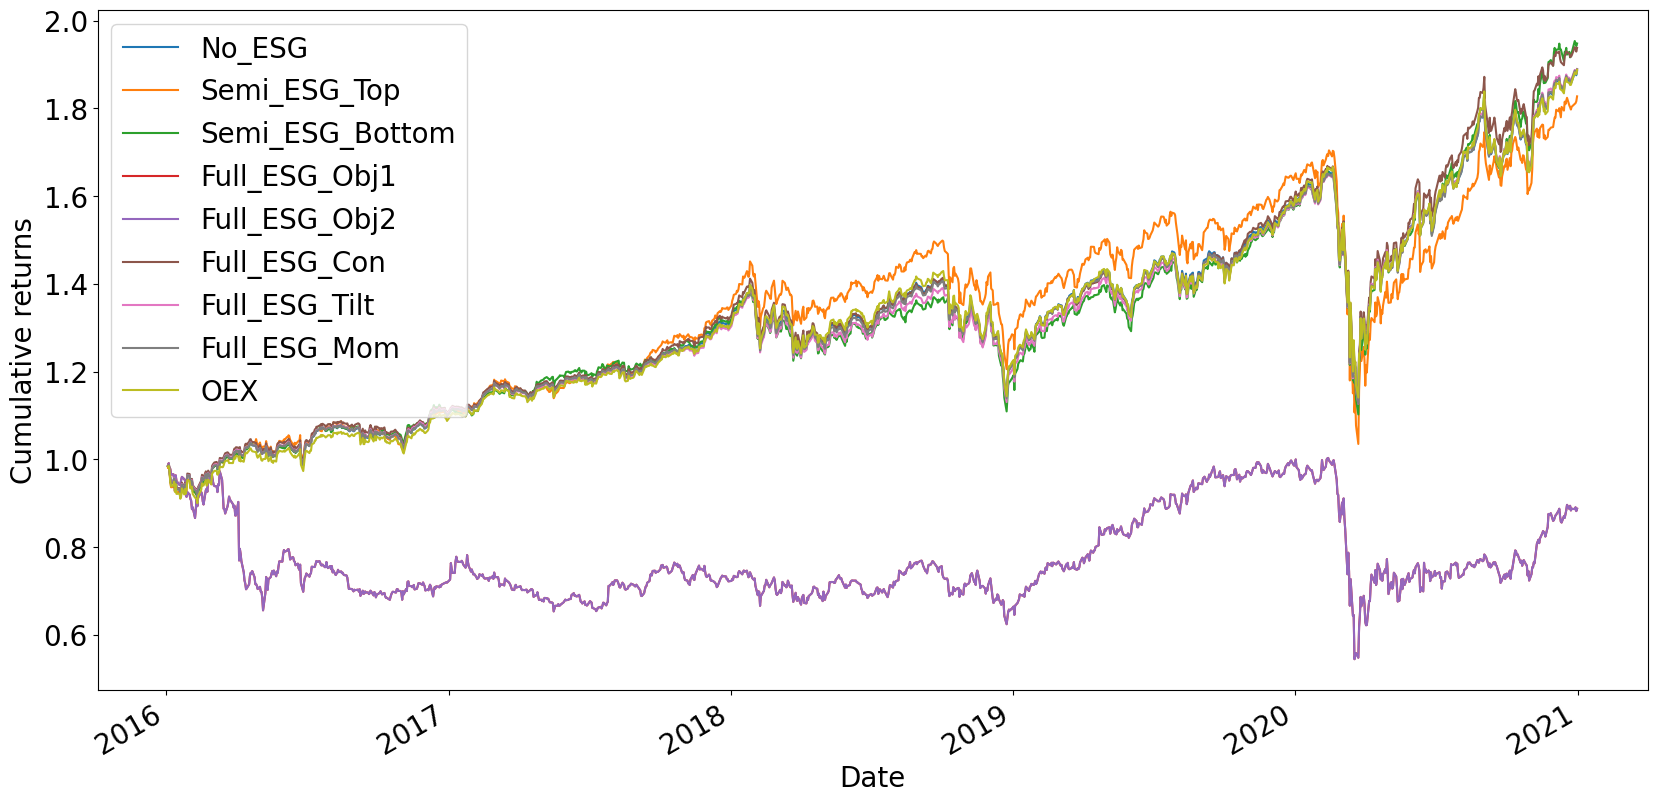

In [26]:
PnL_betas_cumulative.plot(figsize=(20,10))
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Cumulative returns", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

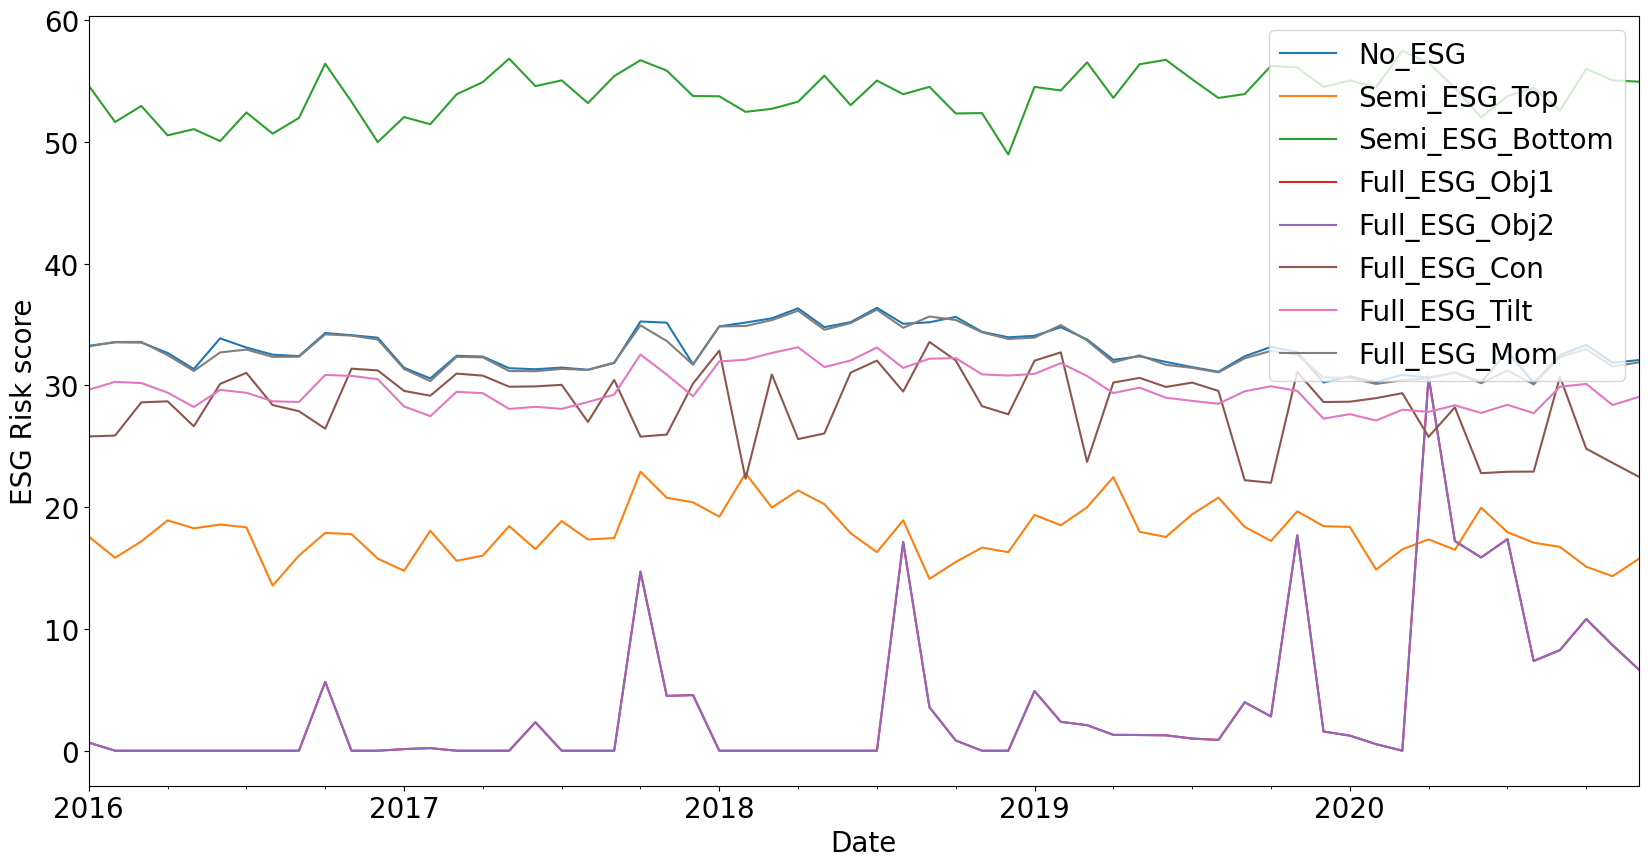

In [27]:
ESG_df_betas.resample('M').mean().dropna().plot(figsize=(20,10))
plt.xlabel("Date", fontsize = 20)
plt.ylabel("ESG Risk score", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

# Trade-off Analysis

In [28]:
timeframes = list(point_in_time_monthly.columns)
PnL_obj1_df = pd.DataFrame(index = price_returns.index, columns = ["No ESG", "Allow 5% less returns",
                                                                    "Allow 10% less returns", "Allow 15% less returns",
                                                                    "Allow 20% less returns", "Allow 25% less returns"])
ESG_obj1_df = pd.DataFrame(index = price_returns.index, columns = ["No ESG", "Allow 5% less returns",
                                                                    "Allow 10% less returns", "Allow 15% less returns",
                                                                    "Allow 20% less returns", "Allow 25% less returns"])

PnL_obj2_df = pd.DataFrame(index = price_returns.index, columns = ["No ESG", "Allow 5% more risk",
                                                                    "Allow 10% more risk", "Allow 15% more risk",
                                                                    "Allow 20% more risk", "Allow 25% more risk"])
ESG_obj2_df = pd.DataFrame(index = price_returns.index, columns = ["No ESG", "Allow 5% more risk",
                                                                    "Allow 10% more risk", "Allow 15% more risk",
                                                                    "Allow 20% more risk", "Allow 25% more risk"])

for year in range (2015, 2021):
  for month in range(1, 13):

    if(month == 1): print(year)
    if year == 2015 and month != 12: continue
    if year == 2020 and month == 12: break

    # filter data for universe in current time frame
    sliced_data_returns = price_returns[(price_returns["year"] >= year-1)  & (price_returns["year"] <= year)]
    sliced_data_returns1 = sliced_data_returns[(price_returns["year"] == year-1) & (price_returns["month"] > month)]
    sliced_data_returns2 = sliced_data_returns[(price_returns["year"] == year) & (price_returns["month"] <= month)]
    sliced_data_returns = pd.concat([sliced_data_returns1, sliced_data_returns2], axis = 0)

    sliced_data_esg = esg_data[(esg_data["year"] == year) & (esg_data["month"] == month)]
    uni_index = timeframes.index(str(year)+'-'+str(month))+1
    univ = list(point_in_time_monthly.iloc[:,uni_index])
    univ_found = [i for i in univ if i in tickers_found]
    sliced_data_returns = sliced_data_returns[univ_found].dropna(axis = 1, how = 'any')
    univ_found = list(sliced_data_returns.columns)
    sliced_data_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
    holding_returns = price_returns[(price_returns["year"] == int(timeframes[uni_index][:4])) & 
                                    (price_returns["month"] == int(timeframes[uni_index][5:]))][univ_found]
    holding_esg = esg_data[(esg_data["year"] == int(timeframes[uni_index][:4])) & 
                                    (esg_data["month"] == int(timeframes[uni_index][5:]))]
    holding_esg = holding_esg[holding_esg.Ticker.isin(univ_found)]
    sector_df = holding_esg[["Ticker", "Sector"]]
    mu = sliced_data_returns.mean()
    Sigma = sliced_data_returns.cov()
    
    # strategy 1
    
    no_esg_ret_data, no_esg_risk_data, no_esg_w_data = markowitz(mu, Sigma)
    no_esg_sharpe_data = no_esg_ret_data / no_esg_risk_data
    no_esg_ret = no_esg_ret_data[np.argmax(no_esg_sharpe_data)]
    no_esg_risk = no_esg_risk_data[np.argmax(no_esg_sharpe_data)]
    no_esg_weights = no_esg_w_data[np.argmax(no_esg_sharpe_data)]
    no_esg_score = no_esg_weights @ sliced_data_esg.current_RRI.values
    PnL_obj1_df.loc[holding_returns.index, 'No ESG'] = (holding_returns * no_esg_weights).sum(axis=1)
    PnL_obj2_df.loc[holding_returns.index, 'No ESG'] = (holding_returns * no_esg_weights).sum(axis=1)
    ESG_obj1_df.loc[holding_returns.index, 'No ESG'] = no_esg_weights @ holding_esg.current_RRI.values
    ESG_obj2_df.loc[holding_returns.index, 'No ESG'] = no_esg_weights @ holding_esg.current_RRI.values

    # strategy 3
    # esg in objective (1 - vary min returns needed, 2 - vary max risk allowed)

    for i in range(5, 30, 5):

      full_esg_obj1_ret, full_esg_obj1_risk, full_esg_obj1_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                  None, no_esg_ret-abs(no_esg_ret)*(i/100), no_esg_risk)
      full_esg_obj1_score = full_esg_obj1_weights @ sliced_data_esg.current_RRI.values
      name = "Allow " + str(i) + "% less returns"
      PnL_obj1_df.loc[holding_returns.index, name] = (holding_returns * full_esg_obj1_weights).sum(axis=1)
      ESG_obj1_df.loc[holding_returns.index, name] = full_esg_obj1_weights @ holding_esg.current_RRI.values
      
      full_esg_obj2_ret, full_esg_obj2_risk, full_esg_obj2_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                  None, no_esg_ret, no_esg_risk*(1+i/100))
      full_esg_obj2_score = full_esg_obj2_weights @ sliced_data_esg.current_RRI.values
      name = "Allow " + str(i) + "% more risk"
      PnL_obj2_df.loc[holding_returns.index, name] = (holding_returns * full_esg_obj2_weights).sum(axis=1)
      ESG_obj2_df.loc[holding_returns.index, name] = full_esg_obj2_weights @ holding_esg.current_RRI.values

2015
2016
2017
2018
2019
2020


In [29]:
PnL_df_final = PnL_obj1_df.dropna()
PnL_df_final["OEX"] = oex_returns.loc[PnL_df_final.index,'Adj Close']
PnL_cumulative = (1 + PnL_df_final).cumprod()
PnL_cumulative

,No ESG,Allow 5% less returns,Allow 10% less returns,Allow 15% less returns,Allow 20% less returns,Allow 25% less returns,OEX
Date,,,,,,,
2016-01-04,0.957106,0.958196,0.960508,0.962749,0.964959,0.967148,0.983663
2016-01-05,0.958224,0.958313,0.960527,0.962982,0.965547,0.968185,0.984892
2016-01-06,0.953968,0.951975,0.953005,0.95449,0.956176,0.957997,0.972955
2016-01-07,0.921367,0.925236,0.92947,0.933418,0.937244,0.940989,0.948488
2016-01-08,0.917572,0.922274,0.925153,0.928193,0.931308,0.934474,0.938723
...,...,...,...,...,...,...,...
2020-12-24,2.903513,2.540722,2.286981,2.079901,1.863996,1.691433,1.859507
2020-12-28,2.912305,2.533284,2.274345,2.068598,1.853388,1.681015,1.881889
2020-12-29,2.913525,2.539812,2.27999,2.074683,1.859242,1.68644,1.879706


In [30]:
stats_df = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_df_final.columns)
stats_df.loc["Ann_Returns_comp", :] = PnL_cumulative.iloc[-1,:] ** (1/5) - 1
ann_return = PnL_df_final.mean(axis=0) * 252
ann_vol = PnL_df_final.std(axis=0) * (252)**(0.5)
stats_df.loc["Ann_Vol", :] = ann_vol
stats_df.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_df_final.sub(PnL_df_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_df.loc["Tracking_error", :] = tracking_error
stats_df.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_cumulative - PnL_cumulative.cummax())/ PnL_cumulative.cummax()).min(axis=0)
stats_df.loc["Max_drawdown", :] = mdd
stats_df.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_df_final[PnL_df_final<0].std(axis=0) * (252)**(0.5)
stats_df.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_df.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_df.loc["Avg_ESG", :] = ESG_obj1_df.mean(axis=0)
stats_df.loc["Sharpe/ESG", :] = stats_df.loc["Ann_Sharpe", :] / ESG_obj1_df.mean(axis=0)
stats_df.apply(lambda x: round(x.astype(float), 3))

,No ESG,Allow 5% less returns,Allow 10% less returns,Allow 15% less returns,Allow 20% less returns,Allow 25% less returns,OEX
Ann_Returns_comp,0.247,0.211,0.185,0.162,0.136,0.113,0.135
Ann_Vol,0.257,0.250,0.246,0.243,0.240,0.238,0.192
Ann_Sharpe,0.988,0.893,0.812,0.739,0.651,0.571,0.759
Tracking_error,0.180,0.162,0.155,0.149,0.145,0.142,NaN
Information_ratio,0.604,0.475,0.350,0.228,0.075,-0.068,NaN
Max_drawdown,-0.324,-0.330,-0.332,-0.334,-0.339,-0.341,-0.315
Calmar_Ratio,0.785,0.675,0.603,0.538,0.462,0.399,0.462
Sortino_ratio,1.162,1.047,0.962,0.882,0.776,0.681,0.845
95var,-0.171,-0.189,-0.207,-0.221,-0.240,-0.257,-0.171
Avg_ESG,35.980,26.997,23.532,20.962,18.863,17.090,NaN


In [31]:
PnL_df_final = PnL_obj2_df.dropna()
PnL_df_final["OEX"] = oex_returns.loc[PnL_df_final.index,'Adj Close']
PnL_cumulative = (1 + PnL_df_final).cumprod()
PnL_cumulative

,No ESG,Allow 5% more risk,Allow 10% more risk,Allow 15% more risk,Allow 20% more risk,Allow 25% more risk,OEX
Date,,,,,,,
2016-01-04,0.957106,0.95613,0.956336,0.956361,0.956361,0.956361,0.983663
2016-01-05,0.958224,0.955266,0.954568,0.954484,0.954484,0.954484,0.984892
2016-01-06,0.953968,0.949352,0.948024,0.947865,0.947865,0.947865,0.972955
2016-01-07,0.921367,0.92201,0.922845,0.922945,0.922945,0.922945,0.948488
2016-01-08,0.917572,0.918823,0.918344,0.918287,0.918287,0.918287,0.938723
...,...,...,...,...,...,...,...
2020-12-24,2.903513,2.650427,2.516575,2.438206,2.363798,2.337065,1.859507
2020-12-28,2.912305,2.638276,2.508822,2.430694,2.356515,2.329864,1.881889
2020-12-29,2.913525,2.644472,2.51735,2.438957,2.364525,2.337784,1.879706


In [32]:
stats_df = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_df_final.columns)
stats_df.loc["Ann_Returns_comp", :] = PnL_cumulative.iloc[-1,:] ** (1/5) - 1
ann_return = PnL_df_final.mean(axis=0) * 252
ann_vol = PnL_df_final.std(axis=0) * (252)**(0.5)
stats_df.loc["Ann_Vol", :] = ann_vol
stats_df.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_df_final.sub(PnL_df_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_df.loc["Tracking_error", :] = tracking_error
stats_df.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_cumulative - PnL_cumulative.cummax())/ PnL_cumulative.cummax()).min(axis=0)
stats_df.loc["Max_drawdown", :] = mdd
stats_df.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_df_final[PnL_df_final<0].std(axis=0) * (252)**(0.5)
stats_df.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_df.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_df.loc["Avg_ESG", :] = ESG_obj2_df.mean(axis=0)
stats_df.loc["Sharpe/ESG", :] = stats_df.loc["Ann_Sharpe", :] / ESG_obj2_df.mean(axis=0)
stats_df.apply(lambda x: round(x.astype(float), 3))

,No ESG,Allow 5% more risk,Allow 10% more risk,Allow 15% more risk,Allow 20% more risk,Allow 25% more risk,OEX
Ann_Returns_comp,0.247,0.222,0.210,0.202,0.195,0.192,0.135
Ann_Vol,0.257,0.259,0.265,0.270,0.276,0.280,0.192
Ann_Sharpe,0.988,0.903,0.853,0.817,0.784,0.768,0.759
Tracking_error,0.180,0.171,0.172,0.175,0.178,0.181,NaN
Information_ratio,0.604,0.515,0.464,0.430,0.396,0.384,NaN
Max_drawdown,-0.324,-0.330,-0.331,-0.332,-0.331,-0.326,-0.315
Calmar_Ratio,0.785,0.710,0.682,0.665,0.652,0.661,0.462
Sortino_ratio,1.162,1.071,1.026,0.990,0.955,0.939,0.845
95var,-0.171,-0.193,-0.211,-0.225,-0.239,-0.247,-0.171
Avg_ESG,35.980,27.314,24.598,22.990,21.859,21.045,NaN
